# Converting the Spotify Dataset
This Jupyter Notebook will convert the dataset in `dataset/songs_normalize.csv` to and updated version of the dataset. The main updates are below.

- Append a new column for each genre in the original `genres` column. The value of each column is either True if that song is part of that genre, or False otherwise.
- Append a new column called `hasFeature` based on whether the song has a feature on the song title. A song is classified as having a "feature" if the title has one of the following keywords: `'feature', 'feat', 'ft', 'featuring', '(with', 'vs', 'vs.'`.

The updated dataset is stored in `dataset/songs_updated_v4.csv`.

In [1]:
import pandas as pd

In [2]:
# Load dataset
song_df = pd.read_csv('../dataset/songs_normalize.csv')


## Adding the `isGenre` columns
To create a new column for each genre, first we must find all the possible genres based on the values in the dataset. The original genre column contains a comma-separated list of genres. This will create a `set` with all the values of genre that we can find.

Then we create a dictionary with the key as the genre name and the values as a list of boolean values based on whether the song is part of the genre or not.

There are a few caveats to note:
- There are a few data points with no genre. Their values are `set()`. Instead of including that column, we remove that column.
- We prefix the new column names with `is`. As an example, `ispop` is one of the columns.

In [3]:
# Get list of all genres
genre_set = set()
for genres in song_df['genre'].values:
    genre_list = genres.split(',')
    for genre in genre_list:
        genre_set.add(genre.strip())
print(genre_set)

{'jazz', 'country', 'rock', 'pop', 'hip hop', 'Folk/Acoustic', 'R&B', 'latin', 'Dance/Electronic', 'easy listening', 'set()', 'metal', 'classical', 'blues', 'World/Traditional'}


In [4]:
# Populate a dictionary with the genres as keys and a list of True/False as values
# depending on whether the song is of that genre or not
# Make sure to ignore 'set()'
genre_dict = dict()
for genre in genre_set:
    if genre == 'set()':
        continue
    is_genre = []
    for genres in song_df['genre'].values:
        if genre in genres:
            is_genre.append(True)
        else:
            is_genre.append(False)
    genre_cleaned = 'is_' + genre.lower().replace(' ', '_').replace('/', '_')
    print(f'{genre} -> {genre_cleaned}')
    genre_dict[genre_cleaned] = is_genre

jazz -> is_jazz
country -> is_country
rock -> is_rock
pop -> is_pop
hip hop -> is_hip_hop
Folk/Acoustic -> is_folk_acoustic
R&B -> is_r&b
latin -> is_latin
Dance/Electronic -> is_dance_electronic
easy listening -> is_easy_listening
metal -> is_metal
classical -> is_classical
blues -> is_blues
World/Traditional -> is_world_traditional


In [5]:
# Check output of genre_dict and convert to a data frame
for genre, is_genre in genre_dict.items():
    print(f'{genre}: {is_genre[:5]}')

genres_df = pd.DataFrame(genre_dict)
genres_df.head()

is_jazz: [False, False, False, False, False]
is_country: [False, False, True, False, False]
is_rock: [False, True, False, True, False]
is_pop: [True, True, True, False, True]
is_hip_hop: [False, False, False, False, False]
is_folk_acoustic: [False, False, False, False, False]
is_r&b: [False, False, False, False, False]
is_latin: [False, False, False, False, False]
is_dance_electronic: [False, False, False, False, False]
is_easy_listening: [False, False, False, False, False]
is_metal: [False, False, False, True, False]
is_classical: [False, False, False, False, False]
is_blues: [False, False, False, False, False]
is_world_traditional: [False, False, False, False, False]


,is_jazz,is_country,is_rock,is_pop,is_hip_hop,is_folk_acoustic,is_r&b,is_latin,is_dance_electronic,is_easy_listening,is_metal,is_classical,is_blues,is_world_traditional
0,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,False,True,True,False,False,False,False,False,False,False,False,False,False
2,False,True,False,True,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,True,False,False,False
4,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [6]:
# Append the data frame to the existing one
song_updated_df = song_df.copy()
song_updated_df = pd.concat([song_updated_df, genres_df], axis=1, sort=True)
song_updated_df.head()


,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,...,is_hip_hop,is_folk_acoustic,is_r&b,is_latin,is_dance_electronic,is_easy_listening,is_metal,is_classical,is_blues,is_world_traditional
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,...,False,False,False,False,False,False,False,False,False,False
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,...,False,False,False,False,False,False,False,False,False,False
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,...,False,False,False,False,False,False,False,False,False,False
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,...,False,False,False,False,False,False,True,False,False,False
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,...,False,False,False,False,False,False,False,False,False,False


## Adding the `hasFeature` column
Now, time to search for the list of keywords in a song title to determine whether a song has a feature or not. Once we know this, we can append this new column as well to the dataset.

In [7]:
# Add a hasFeature column
# Cannot use just 'with' as this returns all song titles with 'with' in the actual
# song title. So instead use '(with' which seems to be more accurate
feature_keywords = {'feature', 'feat', 'ft', 'featuring', '(with', 'vs', 'vs.'}

has_feature = []
for song_title in song_df['song']:
    has_feature.append(any(keyword in song_title for keyword in feature_keywords))

In [8]:
# Append new data to existing data frame
song_updated_df['has_feature'] = has_feature

## Remove duplicate song titles
There are some songs that appear in the dataset multiple times because they appear in the top hits of the year playlist on spotify throughout multiple years. This may skew our visualization and training data, so instead I will remove duplicates and add a new column that counts how many times a song has appeared on the top hits playlist.

In [10]:
# dp_rows = song_updated_df.duplicated(subset=['song', 'artist'], keep='last')
# dp_rows = dp_rows[dp_rows == True]
# print(len(dp_rows))

# dp_rows_2 = song_updated_df.duplicated()
# dp_rows_2 = dp_rows_2[dp_rows_2 == True]
# print(len(dp_rows_2))

In [11]:
# song_count = dict()
# for index, row in song_df.iterrows():
#     key = index
#     song_count[key] = song_count.get(key, 0) + 1


In [12]:
song_updated_df.drop_duplicates(inplace=True)

In [13]:
# song_count_list = []
# for index, row in song_updated_df.iterrows():
#     key = row['song'] + '-' + row['artist']
#     song_count_list.append(song_count[key])

# song_updated_df['num_years'] = song_count_list

In [14]:
# song_updated_df[song_updated_df['num_years'] > 1].head()

## Saving the new dataset
The dataset has been updated as we had hoped. Now we can save the new dataset under a new name `songs_updated_v4.csv`!

In [15]:
# Write updated data frame to CSV
song_updated_df.to_csv('../dataset/songs_updated_v4.csv', index=False)

In [16]:
import matplotlib.pyplot as plt
import numpy as np

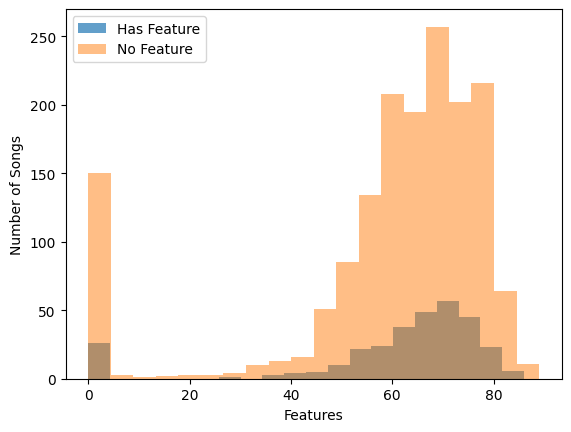

In [17]:
song_has_feature = song_updated_df[song_updated_df['has_feature'] == True]
song_no_feature = song_updated_df[song_updated_df['has_feature'] == False]

plt.hist(song_has_feature['popularity'], bins=20, alpha=0.7, label='Has Feature')
plt.hist(song_no_feature['popularity'], bins=20, alpha=0.5, label='No Feature')
plt.ylabel('Number of Songs')
plt.xlabel('Features')
plt.legend(loc='upper left')
plt.show()

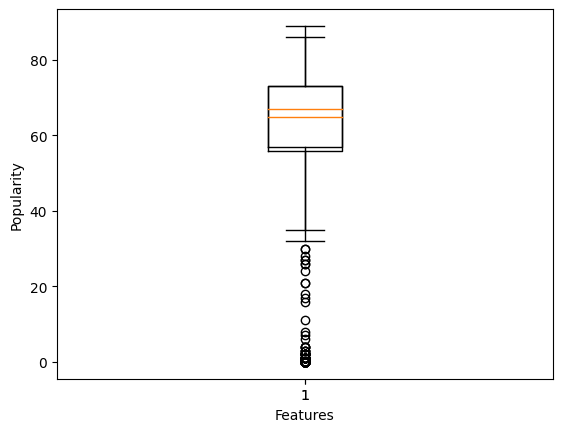

In [18]:
plt.boxplot(song_has_feature['popularity'])
plt.boxplot(song_no_feature['popularity'])
plt.ylabel('Popularity')
plt.xlabel('Features')
plt.show()